<a href="https://colab.research.google.com/github/samiyaalizaidi/Neural-Networks-Projects/blob/main/cats%20and%20dogs/CPE_4903_Project_Cats_Dogs_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center><font color=maroon>CPE4903 Project: Cats and Dogs Classifier</font> </center>

### In this mini-project, you will develop a CNN model for the cat-and-dog classifer.
#### You will create `at least two models`, applying the various techniques we discussed for improving the performance.

1. Deeper Conv layers and/or FC layers
2. Image augmentation
3. Transfer learning
4. Regularization
5. Increasing image size
6. Increasing size of the train/validation/test dataset

* You will compare the performance of your models with the baseline VGG-5 model.  
* <font color=red>Performance requirement: the accuracy on the test data needs to be better than 85% for at least one of your models </font>
* You will save the parameters of the model at the end, which will be deployed on Raspberry Pi.

### Cats & Dogs Dataset

* #### You are given a zip file, `train.zip`, that contains 25,000 labelled images of cats and dogs (12,500 each)
* #### You will select a subset of $N$ image files from the dataset and store them in the following sub-directory structure, where $N$ can be anywhere between 6,000 to 25,000.
* #### The train-validation-test data split is 60%-15%-25%.
<img src="./images/train_test_dir.png" alt="Drawing" style="width: 200px;"/>

### Load tool modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random
import shutil
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

### Load CNN models

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout

In [11]:
from keras.applications.vgg16 import VGG16

### Load the image processing tools

In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

### Load and Process the dataset
__Create the subdirectory structures per the requirement.__

In [13]:
# create a sub-dataset with 10,000 images
folder_path = '/content/drive/MyDrive/train' # original directory
train_sub_path_cat = '/content/sub_folder/cats' # destination directory for cats
train_sub_path_dog = '/content/sub_folder/dogs' # destination directory for dogs

os.makedirs(train_sub_path_cat, exist_ok=True)
os.makedirs(train_sub_path_dog, exist_ok=True)

counter_cat = 0 # to copy only 5000 images for cat
counter_dog = 0 # to copy only 5000 images for dogs

for filename in os.listdir(folder_path):

    src = os.path.join(folder_path, filename) # original path of the image

    if ('cat' in filename) and (counter_cat < 5000):
        dest = os.path.join(train_sub_path_cat, filename) # destination path of the image
        shutil.copy(src, dest)
        counter_cat += 1

    elif ('dog' in filename) and (counter_dog < 5000):
        dest = os.path.join(train_sub_path_dog, filename) # destination path of the image
        shutil.copy(src, dest)
        counter_dog += 1

    # to stop the iteration when the desired number of images have been copied
    if (counter_cat >= 5000) and (counter_dog >= 5000):
        break

print(f'{counter_cat} cat and {counter_dog} dog images successfully copied!')

5000 cat and 5000 dog images successfully copied!


In [14]:
split_folder = '/content/split_folder'

os.makedirs(split_folder, exist_ok=True)

# making the sub folders for train, test, and val

sub_folders = ['train', 'test', 'validation']

for folder in sub_folders:
    path = os.path.join(split_folder, folder)
    os.makedirs(path, exist_ok=True)

    os.makedirs(os.path.join(path, 'cats'), exist_ok=True)
    os.makedirs(os.path.join(path, 'dogs'), exist_ok=True)

In [15]:
# split the dataset
# 65% -> training
# 15% -> validation
# 25% -> test

# List all subfolders (assuming one for cats and one for dogs)
subfolders = [f.path for f in os.scandir('/content/sub_folder') if f.is_dir()]
print("The subfolders are:", subfolders)

for subfolder in subfolders:
    # List all images in the current subfolder

    images = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith(('.jpg', '.jpeg', '.png'))]

    # Split images into train, test, and validation sets
    train_images, test_val_images = train_test_split(images, test_size=0.35, random_state=42)
    test_images, val_images = train_test_split(test_val_images, test_size=0.43, random_state=42)


    # Copy images to the respective folders
    for image in train_images:
        name = os.path.join('/content/split_folder/train', os.path.basename(subfolder))
        shutil.copy(image, os.path.join(name, os.path.basename(image)))

    for image in test_images:
        name = os.path.join('/content/split_folder/test', os.path.basename(subfolder))
        shutil.copy(image, os.path.join(name, os.path.basename(image)))

    for image in val_images:
        name = os.path.join('/content/split_folder/validation', os.path.basename(subfolder))
        shutil.copy(image, os.path.join(name, os.path.basename(image)))



The subfolders are: ['/content/sub_folder/dogs', '/content/sub_folder/cats']


In [16]:
datagen = ImageDataGenerator(
           rescale=1.0/255.0,
           rotation_range=15,
           width_shift_range=0.1,
           height_shift_range=0.1,
           zoom_range=0.2,
           horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = datagen.flow_from_directory(split_folder + '/train',
            class_mode='binary', batch_size=256, target_size=(224, 224))

val_data = val_datagen.flow_from_directory(split_folder + '/validation',
           class_mode='binary', batch_size=256, target_size=(224, 224))

test_data = val_datagen.flow_from_directory(split_folder + '/test',
            class_mode='binary', batch_size=256, target_size=(224, 224))

Found 6500 images belonging to 2 classes.
Found 1506 images belonging to 2 classes.
Found 1994 images belonging to 2 classes.


### Display 2 input images: one for dog, and one for cat

In [18]:
from IPython.display import display, Image as IPImage

dogs


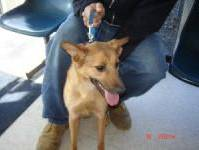


cats


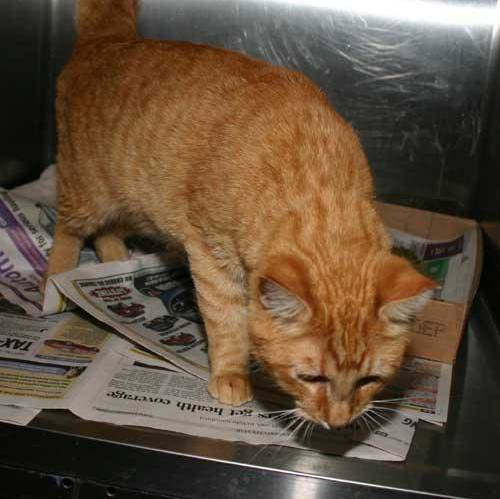

In [19]:
def display_images(folder_path):
    # Get the list of subfolders
    subfolders = [subfolder for subfolder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subfolder))]

    # Display one image from each subfolder
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        image_files = [file for file in os.listdir(subfolder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if image_files:
            # Display the first image in the subfolder
            image_path = os.path.join(subfolder_path, image_files[0])
            print(os.path.basename(subfolder))
            display(IPImage(filename=image_path, format='png'))
            print()

# Replace 'your_folder_path' with the path to your main folder containing subfolders.
folder_path = '/content/split_folder/validation'
display_images(folder_path)


# <font color=blue>Build CNN Model One</font>

## <font color=green>Define the CNN model</font>

__Use CONV, POOL and FC layers to construct your CNN model. You can also load pre-trained model, if transfer learning is used. You will train and test the model after this step.__

In [20]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))    # include_top=False: FC layers are NOT frozen

# Freeze the convolutional layers

for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add the VGG-16 base model

model_1 = Sequential()
model_1.add(base_model)

model_1.add(Flatten())

# FC Layers for new classifier

model_1.add(Dense(units=1024, activation='relu'))
model_1.add(Dropout(0.3))
model_1.add(Dense(1, activation='sigmoid'))

### Print the model summary that shows the output shape and # of parameters for each layer.

In [21]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              25691136  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 40406849 (154.14 MB)
Trainable params: 25692161 (98.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


### <font color=red>Question: What are the total number of parameters for the model?</font>

40406849

## <font color=green>Train the CNN Model</font>

__Note: Display the history when running model.fit( )__

In [22]:
model_1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [23]:
history = model_1.fit(train_data, epochs=10, validation_data = val_data, verbose=1)

Epoch 1/10
26/26 [==============================] - 103s 3s/step - loss: 2.2226 - accuracy: 0.6989 - val_loss: 0.3145 - val_accuracy: 0.8838
Epoch 2/10
26/26 [==============================] - 33s 1s/step - loss: 0.2729 - accuracy: 0.8917 - val_loss: 0.2040 - val_accuracy: 0.9203
Epoch 3/10
26/26 [==============================] - 37s 1s/step - loss: 0.1739 - accuracy: 0.9295 - val_loss: 0.1762 - val_accuracy: 0.9316
Epoch 4/10
26/26 [==============================] - 34s 1s/step - loss: 0.1283 - accuracy: 0.9529 - val_loss: 0.1675 - val_accuracy: 0.9349
Epoch 5/10
26/26 [==============================] - 34s 1s/step - loss: 0.1076 - accuracy: 0.9626 - val_loss: 0.1635 - val_accuracy: 0.9343
Epoch 6/10
26/26 [==============================] - 35s 1s/step - loss: 0.0850 - accuracy: 0.9722 - val_loss: 0.1660 - val_accuracy: 0.9369
Epoch 7/10
26/26 [==============================] - 35s 1s/step - loss: 0.0707 - accuracy: 0.9805 - val_loss: 0.1703 - val_accuracy: 0.9336
Epoch 8/10
26/26 [=

### <font color=red>Question: What is the estimated total model training time?</font>

$40s \times 26 = 1040s = 17.33$ minutes.


### Compare Loss and Accuracy Performance for train and validation data

#### Plot the loss data, for both train and validation data

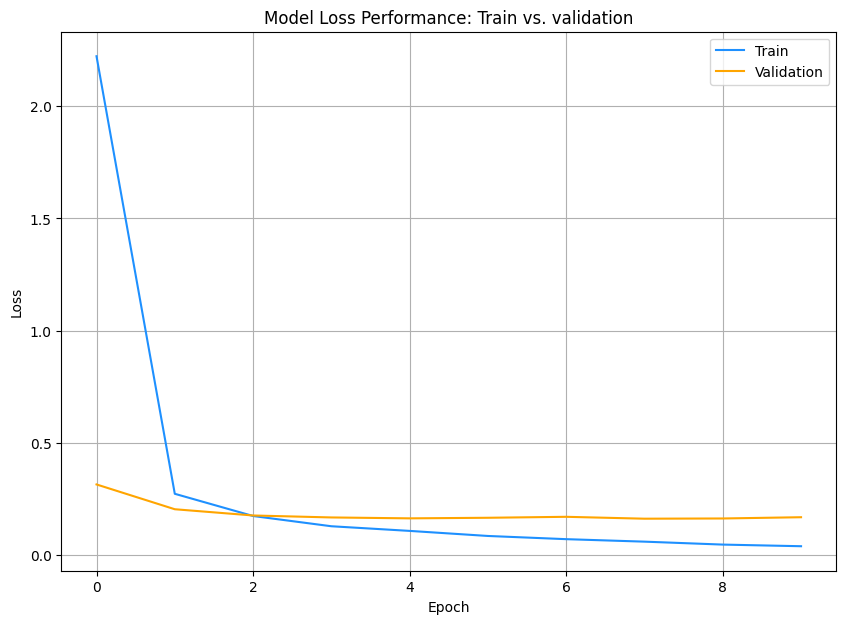

In [24]:
J = history.history['loss']  # Loss data for Training
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

#### Plot the accuracy data, for both train and validation data

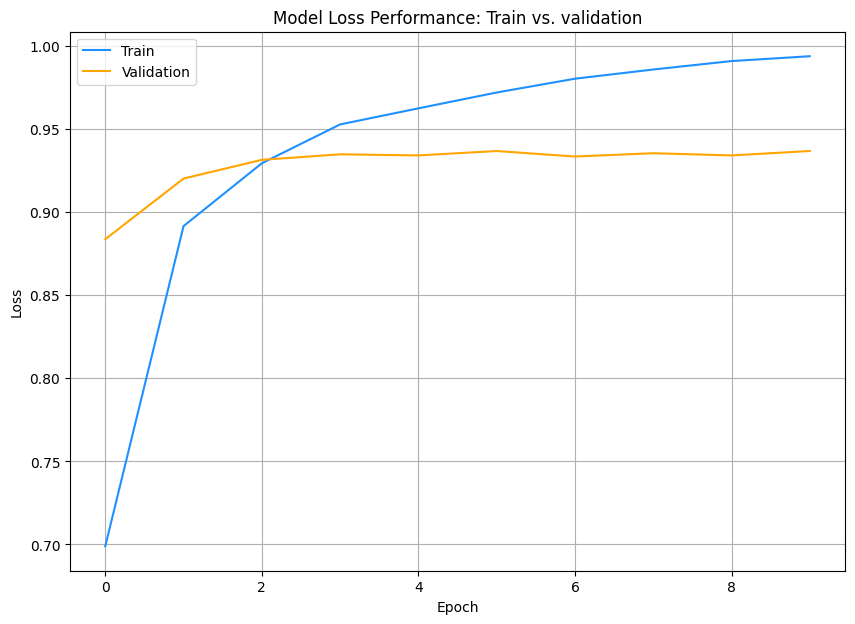

In [25]:
J = history.history['accuracy']  # Loss data for Training
J_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

## <font color=green>Test the CNN Model</font>
__Note: Display the history when running model.evaluate( )__

In [26]:
loss, accuracy = model_1.evaluate(test_data, verbose=1)

8/8 [==============================] - 24s 3s/step - loss: 0.1851 - accuracy: 0.9263


In [27]:
y_pred = model_1.predict(test_data)

8/8 [==============================] - 9s 1s/step


In [28]:
Y_pred = np.rint(y_pred)    # Binary decision on the image. 1 = Dog, 0 = Cat

y_pred[0], Y_pred[0]

(array([0.14117648], dtype=float32), array([0.], dtype=float32))

### <font color=red>Question: What is the estimated inference (testing) time on test dataset?</font>

8s per image





### Print the final loss and accuracy of the test data

In [29]:
print(f'Loss = {loss:.4f}, Accuracy = {(accuracy * 100):.4f}%')

Loss = 0.1851, Accuracy = 92.6279%


### Save the CNN model parameters

In [30]:
model_1.save('CATS_DOGS_MODEL_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# <font color=blue>Build CNN Model Two</font>

__For your second and subsequent models, follow the same set of instructions provided for Model One__

In [5]:
# create a sub-dataset with 10,000 images
folder_path = '/content/drive/MyDrive/train' # original directory
train_sub_path_cat = '/content/sub_folder_2/cats' # destination directory for cats
train_sub_path_dog = '/content/sub_folder_2/dogs' # destination directory for dogs

os.makedirs(train_sub_path_cat, exist_ok=True)
os.makedirs(train_sub_path_dog, exist_ok=True)

counter_cat = 0 # to copy only 10000 images for cat
counter_dog = 0 # to copy only 10000 images for dogs

for filename in os.listdir(folder_path):

    src = os.path.join(folder_path, filename) # original path of the image

    if ('cat' in filename) and (counter_cat < 4000):
        dest = os.path.join(train_sub_path_cat, filename) # destination path of the image
        shutil.copy(src, dest)
        counter_cat += 1

    elif ('dog' in filename) and (counter_dog < 4000):
        dest = os.path.join(train_sub_path_dog, filename) # destination path of the image
        shutil.copy(src, dest)
        counter_dog += 1

    # to stop the iteration when the desired number of images have been copied
    if (counter_cat >= 4000) and (counter_dog >= 4000):
        break


print(f'{counter_cat} cat and {counter_dog} dog images successfully copied!')

4000 cat and 4000 dog images successfully copied!


In [6]:
split_folder = '/content/split_folder_2'

os.makedirs(split_folder, exist_ok=True)

# making the sub folders for train, test, and val

sub_folders = ['train', 'test', 'validation']

for folder in sub_folders:
    path = os.path.join(split_folder, folder)
    os.makedirs(path, exist_ok=True)

    os.makedirs(os.path.join(path, 'cats'), exist_ok=True)
    os.makedirs(os.path.join(path, 'dogs'), exist_ok=True)

In [7]:
# split the dataset
# 65% -> training
# 15% -> validation
# 25% -> test

# List all subfolders (assuming one for cats and one for dogs)
subfolders = [f.path for f in os.scandir('/content/sub_folder_2') if f.is_dir()]
print("The subfolders are:", subfolders)

for subfolder in subfolders:
    # List all images in the current subfolder

    images = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith(('.jpg', '.jpeg', '.png'))]

    # Split images into train, test, and validation sets
    train_images, test_val_images = train_test_split(images, test_size=0.35, random_state=42)
    test_images, val_images = train_test_split(test_val_images, test_size=0.43, random_state=42)


    # Copy images to the respective folders
    for image in train_images:
        name = os.path.join('/content/split_folder_2/train', os.path.basename(subfolder))
        shutil.copy(image, os.path.join(name, os.path.basename(image)))

    for image in test_images:
        name = os.path.join('/content/split_folder_2/test', os.path.basename(subfolder))
        shutil.copy(image, os.path.join(name, os.path.basename(image)))

    for image in val_images:
        name = os.path.join('/content/split_folder_2/validation', os.path.basename(subfolder))
        shutil.copy(image, os.path.join(name, os.path.basename(image)))



The subfolders are: ['/content/sub_folder_2/dogs', '/content/sub_folder_2/cats']


In [8]:
datagen = ImageDataGenerator(
           rescale=1.0/255.0,
           rotation_range=15,
           width_shift_range=0.1,
           height_shift_range=0.1,
           zoom_range=0.2,
           horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_data = datagen.flow_from_directory(split_folder + '/train',
            class_mode='binary', batch_size=64, target_size=(64, 64))

val_data = val_datagen.flow_from_directory(split_folder + '/validation',
           class_mode='binary', batch_size=64, target_size=(64, 64))

test_data = val_datagen.flow_from_directory(split_folder + '/test',
            class_mode='binary', batch_size=64, target_size=(64, 64))

Found 5200 images belonging to 2 classes.
Found 1204 images belonging to 2 classes.
Found 1596 images belonging to 2 classes.


dogs


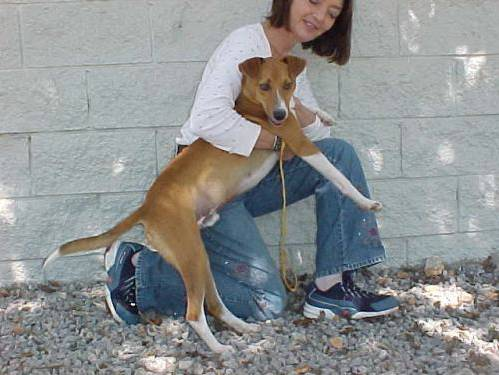


cats


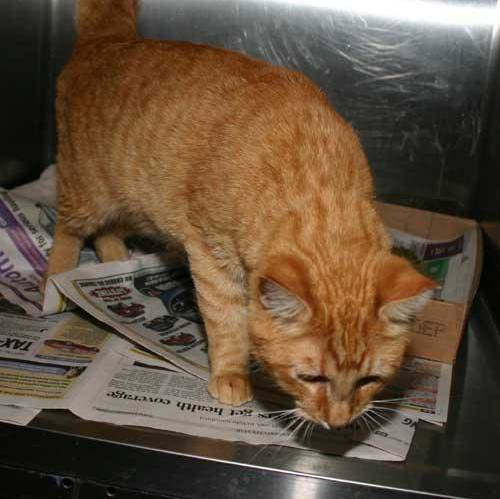

In [10]:
# display images
from IPython.display import display, Image as IPImage

def display_images(folder_path):
    # Get the list of subfolders
    subfolders = [subfolder for subfolder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subfolder))]

    # Display one image from each subfolder
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        image_files = [file for file in os.listdir(subfolder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if image_files:
            # Display the first image in the subfolder
            image_path = os.path.join(subfolder_path, image_files[0])
            print(os.path.basename(subfolder))
            display(IPImage(filename=image_path, format='png'))
            print()

folder_path = '/content/split_folder_2/validation'
display_images(folder_path)

In [23]:
model_2 = Sequential()

# Layer 1
model_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model_2.add(MaxPooling2D((2, 2)))
# output => (32, 32, 32)

# Layer 2
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D((2, 2)))
# output => (15, 15, 64)

# Layer 3
model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(MaxPooling2D((2, 2)))
# output => (6, 6, 128)

# Layer 4
model_2.add(Conv2D(256, (3, 3), activation='relu'))
model_2.add(MaxPooling2D((2, 2)))
# output => (2, 2, 256)

model_2.add(Flatten())

# FC Layers
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(1, activation='sigmoid'))

In [24]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 128)        

Total Params: 25285249

In [25]:
model_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [34]:
history = model_2.fit(train_data, epochs=50, validation_data = val_data, verbose=1)

Epoch 1/50
82/82 [==============================] - 19s 231ms/step - loss: 0.6050 - accuracy: 0.6785 - val_loss: 0.5923 - val_accuracy: 0.6678
Epoch 2/50
82/82 [==============================] - 17s 213ms/step - loss: 0.6070 - accuracy: 0.6875 - val_loss: 0.5878 - val_accuracy: 0.7002
Epoch 3/50
82/82 [==============================] - 18s 215ms/step - loss: 0.5673 - accuracy: 0.7110 - val_loss: 0.5493 - val_accuracy: 0.7201
Epoch 4/50
82/82 [==============================] - 17s 213ms/step - loss: 0.5595 - accuracy: 0.7175 - val_loss: 0.5605 - val_accuracy: 0.7002
Epoch 5/50
82/82 [==============================] - 18s 217ms/step - loss: 0.5442 - accuracy: 0.7452 - val_loss: 0.5403 - val_accuracy: 0.7309
Epoch 6/50
82/82 [==============================] - 17s 213ms/step - loss: 0.5290 - accuracy: 0.7431 - val_loss: 0.5015 - val_accuracy: 0.7475
Epoch 7/50
82/82 [==============================] - 17s 213ms/step - loss: 0.5217 - accuracy: 0.7560 - val_loss: 0.4915 - val_accuracy: 0.7691

### Time taken for training
$18 \times 50 = 900s = 15$ minutes.

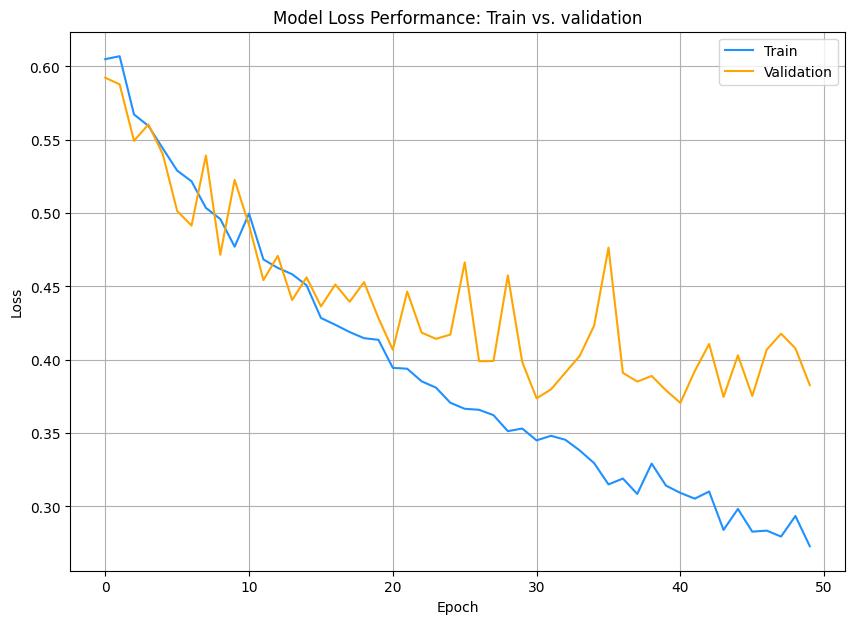

In [35]:
# loss data for train and validation
J = history.history['loss']  # Loss data for Training
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

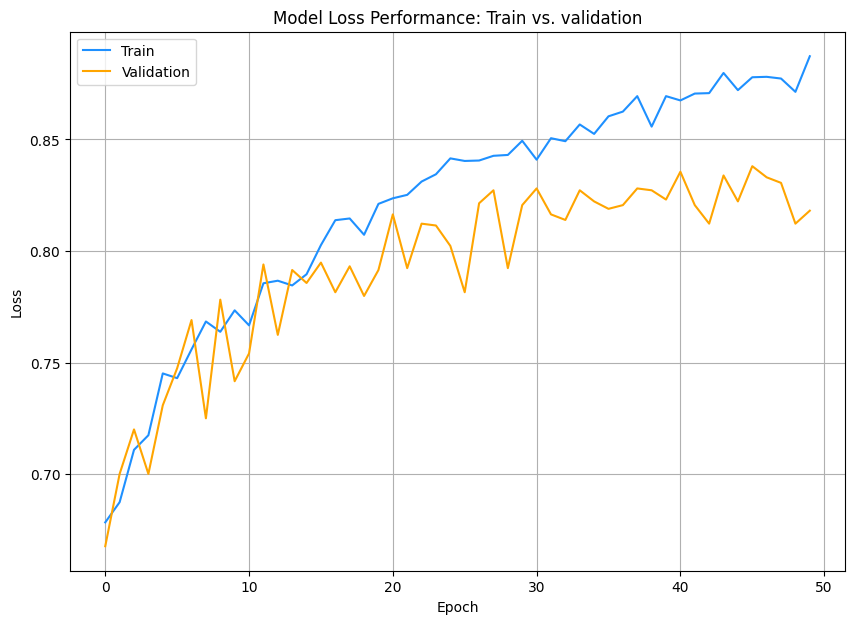

In [36]:
# accuracy data for train and validation
J = history.history['accuracy']  # accuracy data for Training
J_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

In [37]:
loss, accuracy = model_2.evaluate(test_data, verbose=1)

25/25 [==============================] - 2s 89ms/step - loss: 0.4086 - accuracy: 0.8264


In [38]:
y_pred = model_2.predict(test_data)

25/25 [==============================] - 3s 104ms/step


In [39]:
Y_pred = np.rint(y_pred)    # Binary decision on the image. 1 = Dog, 0 = Cat

y_pred[0], Y_pred[0]

(array([0.67898417], dtype=float32), array([1.], dtype=float32))

In [40]:
print(f'Loss = {loss:.4f}, Accuracy = {(accuracy * 100):.4f}%')

Loss = 0.4086, Accuracy = 82.6441%


In [41]:
model_2.save('CATS_DOGS_MODEL_2.h5')

## <font color=green>Conclusion</font>

### You will fill out information in this table:
| Model              | Accuracy | Number of Parameters | Training Time | Inference Speed |
|-------------------- |----------|-----------------------|--------------- |------------------|
| Baseline VGG-5     |    80.8\%      |           683,329            |         ~16 minutes       |       ~3 seconds           |
| Model One           |   92.73\%       |      40406849           |         ~17 minutes       |        ~8 seconds          |
| Model Two           |    82.64\%      |           692033         |        ~15 minutes        |      ~3 seconds            |
| Model Three         |          |                       |                |                  |


__You can also add comments on what you tried and observed while working on the project.__

## Model 1:
### First attempt:
Just ran the model with 4 conv layers and 5 FC layers, with 10 epochs, just to see how it performs. Got horrible results. 58\% training accuracy and 57\% validation accuracy.

### Second attempt:
Running the same model as the previous attempt, but used image augmentation this time along with increasing the image size.

### Third attempt:
Used transfer learning - VGG16. Image size used was 224x224, along with augmentation. Trained for 10 epochs, got a testing accuracy of 92\%

## Model 2:
### First attempt:
Added extra layers to the baseline VGG-5 model and used image augmentation. Trained for 50 epochs. Increased the number of training and validation images.



## <center><font color=maroon>Remember to turn in both the notebook and the pdf version.</font></center>